# IMPORT

In [26]:
import os.path as osp
import glob
import torch
import os
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from FinalModels.ESRGAN.model import ESRGAN

# Set the project root and model path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_path = os.path.join(project_root, "FinalModels", "ESRGAN", "model", "RRDB_PSNR_x4.pth")

# Initialize device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ESRGAN(model_path=model_path, device=device)

# Folder path for test images
folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"

# List files in the folder
print(f"Test images folder: {folder_path}")
for filename in os.listdir(folder_path):
    print('asd', filename)



Test images folder: d:\workspace\ThesisProject\TESTS\images\LR
asd 1.png
asd Balistapus Undulatus-notenhanced.png
asd car.jpeg
asd Chaetodon Trifascialis.jpg
asd fish_000001229596_03681.png
asd fish_000013099594_03543.png
asd fish_000026690001_02685.png
asd fish_000065789596_04756.png
asd notenhanced.png
asd notenhanced2.png
asd notenhanced3.png
asd SAMPLE_LUTJANUS.jpg
asd test_lowres.jpg
asd test_lowres3.jpg


# FUNCTIONS

In [28]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img = transform(img).unsqueeze(0)  
    return img

def downscale_image(image, scale_factor=4):
    _, _, h, w = image.shape
    new_h, new_w = h // scale_factor, w // scale_factor
    image = F.interpolate(image, size=(new_h, new_w), mode='bicubic', align_corners=False)
    return image

def evaluate_performance(hr_image, sr_image):
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bilinear', align_corners=False)
    if hr_image.shape != sr_image.shape:
        print(f"Shape mismatch: HR {hr_image.shape}, SR {sr_image.shape}")
        return None  

    mse = F.mse_loss(sr_image, hr_image)
    
    if mse == 0:
        print("PSNR: Infinite (identical images)")
        return float('inf')  
    
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

    print("=============PSNR Achieved: %f==============" % psnr.item())
    return psnr

def compare_images(hr_image, lr_image, sr_image, psnr):
    """Compare the images by displaying them and printing PSNR."""
    # sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)

    def process_image(img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert (3, H, W) to (H, W, 3)
        else:
            img = np.squeeze(img)  
            if img.ndim == 3 and img.shape[0] in [1, 3]:  # If channel-first, convert to channel-last
                img = np.transpose(img, (1, 2, 0))
        return img


    hr_image = hr_image.cpu().numpy() if isinstance(hr_image, torch.Tensor) else hr_image
    lr_image = lr_image.cpu().numpy() if isinstance(lr_image, torch.Tensor) else lr_image
    sr_image = sr_image.cpu().numpy() if isinstance(sr_image, torch.Tensor) else sr_image
    
    hr_image = np.clip(hr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    hr_image = process_image(hr_image)
    lr_image = process_image(lr_image)
    sr_image = process_image(sr_image)

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(1, 3)
    fig.tight_layout()

    # Plot Original Image
    plt.subplot(131)
    plot_image(hr_image, title="Original")
    
    # Plot Low-Resolution Image
    plt.subplot(132)
    plot_image(lr_image, title="x4 Bicubic")
    
    # Plot Super-Resolved Image
    plt.subplot(133)
    plot_image(sr_image, title="Super Resolution")
    
    plt.show(block=False)
    
def perform_super_resolution(image_path, model, device):
    """Performs super-resolution on an input image."""
    hr_image = preprocess_image(image_path).to(device)
    original = hr_image

    modes = {
        "Bilinear": F.interpolate(hr_image, size=(224, 224), mode='bilinear', align_corners=False),
        "Nearest": F.interpolate(hr_image, size=(224, 224), mode='nearest'),
        "Bicubic": F.interpolate(hr_image, size=(224, 224), mode='bicubic', align_corners=False),
        "Exact": F.interpolate(hr_image, size=(224, 224), mode='nearest-exact')
    }
    
    with torch.no_grad():
        enhanced_image = model(modes['Bicubic'])
    
    return original, enhanced_image, modes

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


# CASE 1: BICUBIC ONLY

In [30]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Bicubic'])

    lr_image = downscale_image(original)


1 1
=============PSNR Achieved: 38.905796==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 53.380871==============
3 car
=============PSNR Achieved: 48.929581==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 36.528893==============
5 fish_000001229596_03681
=============PSNR Achieved: 60.704578==============
6 fish_000013099594_03543
=============PSNR Achieved: 33.204197==============
7 fish_000026690001_02685
=============PSNR Achieved: 58.418240==============
8 fish_000065789596_04756
=============PSNR Achieved: 60.536339==============
9 notenhanced
=============PSNR Achieved: 38.499229==============
10 notenhanced2
=============PSNR Achieved: 44.774811==============
11 notenhanced3
=============PSNR Achieved: 56.677822==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 31.219814==============
13 test_lowres
=============PSNR Achieved: 46.020199==============
14 test_lowres3
=============PSNR Achieved: 54.370724==============


# CASE 2: NEAREST

In [45]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Nearest'])

    lr_image = downscale_image(original)


1 1
=============PSNR Achieved: 31.044752==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 85.350372==============
3 car
=============PSNR Achieved: 35.543324==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 28.711269==============
5 fish_000001229596_03681
PSNR: Infinite (identical images)
6 fish_000013099594_03543
=============PSNR Achieved: 25.851030==============
7 fish_000026690001_02685
PSNR: Infinite (identical images)
8 fish_000065789596_04756
PSNR: Infinite (identical images)
9 notenhanced
=============PSNR Achieved: 30.415329==============
10 notenhanced2
=============PSNR Achieved: 80.077400==============
11 notenhanced3
=============PSNR Achieved: 50.859493==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.373062==============
13 test_lowres
=============PSNR Achieved: 36.000317==============
14 test_lowres3
=============PSNR Achieved: 43.697029==============


# CASE 3: BILINEAR ONLY

In [47]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Bilinear'])

    lr_image = downscale_image(original)


1 1
=============PSNR Achieved: 41.491882==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 46.213120==============
3 Chaetodon Trifascialis
=============PSNR Achieved: 34.834724==============
4 fish_000001229596_03681
=============PSNR Achieved: 50.579647==============
5 fish_000013099594_03543
=============PSNR Achieved: 32.410587==============
6 fish_000026690001_02685
=============PSNR Achieved: 48.671055==============
7 fish_000065789596_04756
=============PSNR Achieved: 50.026886==============
8 notenhanced
=============PSNR Achieved: 36.351479==============
9 notenhanced2
=============PSNR Achieved: 36.267857==============
10 notenhanced3
=============PSNR Achieved: 57.194191==============
11 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.374054==============
12 test_lowres
=============PSNR Achieved: 46.918823==============
13 test_lowres3
=============PSNR Achieved: 52.869839==============


# CASE 4: Nearest Exact

In [ ]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Exact'])

    lr_image = downscale_image(original)


# CASE 5: BICUBIC + ESRGAN

In [31]:


idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, output)

    lr_image = downscale_image(original)




1 1
=============PSNR Achieved: 32.240833==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 60.285908==============
3 car
=============PSNR Achieved: 51.215584==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 38.334896==============
5 fish_000001229596_03681
=============PSNR Achieved: 66.877792==============
6 fish_000013099594_03543
=============PSNR Achieved: 32.837864==============
7 fish_000026690001_02685
=============PSNR Achieved: 64.426567==============
8 fish_000065789596_04756
=============PSNR Achieved: 67.100624==============
9 notenhanced
=============PSNR Achieved: 39.744598==============
10 notenhanced2
=============PSNR Achieved: 47.370663==============
11 notenhanced3
=============PSNR Achieved: 56.800991==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.628653==============
13 test_lowres
=============PSNR Achieved: 47.293438==============
14 test_lowres3
=============PSNR Achieved: 56.408493==============


# PLOTTING THE DIFFERENCE

**ESRGAN + BICUBIC**

1 1
=============PSNR Achieved: 32.240833==============


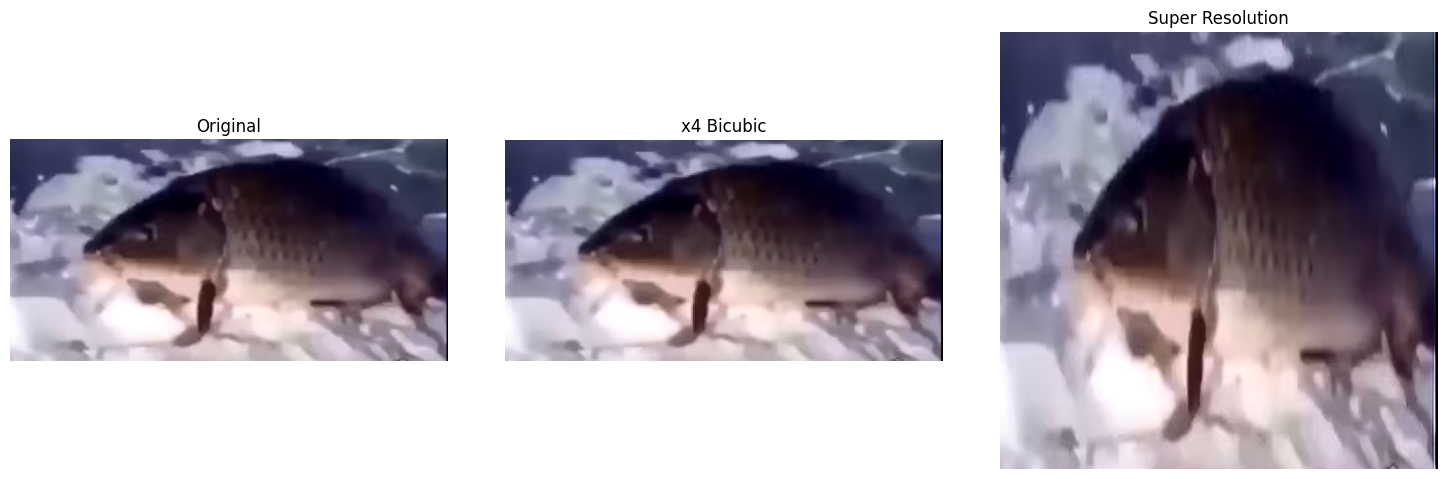

2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 60.285908==============


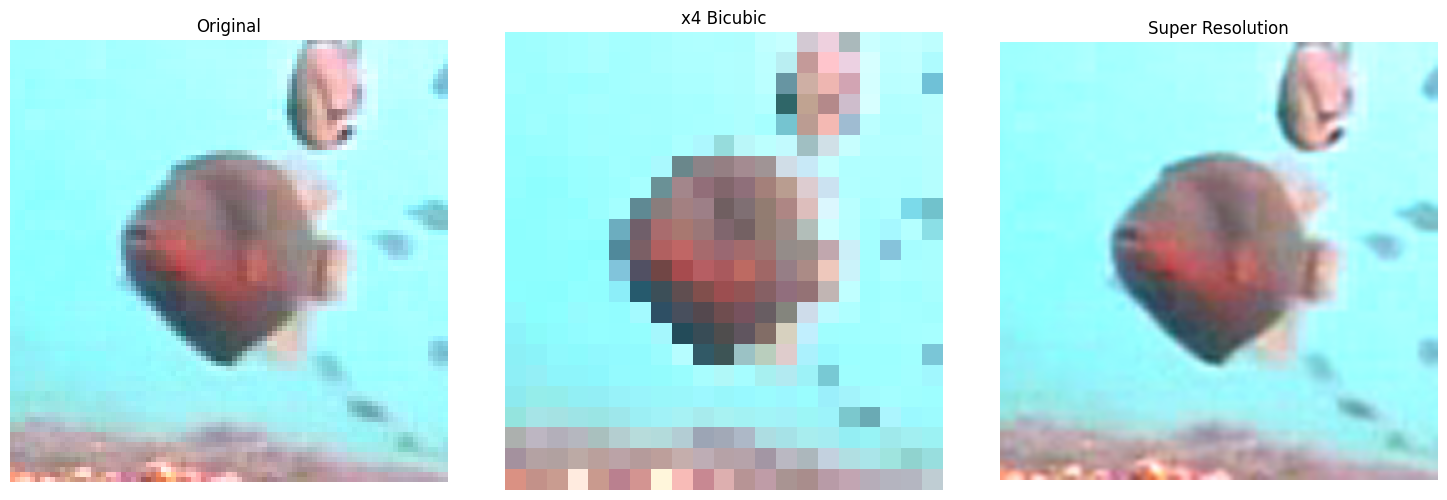

3 car
=============PSNR Achieved: 51.215584==============


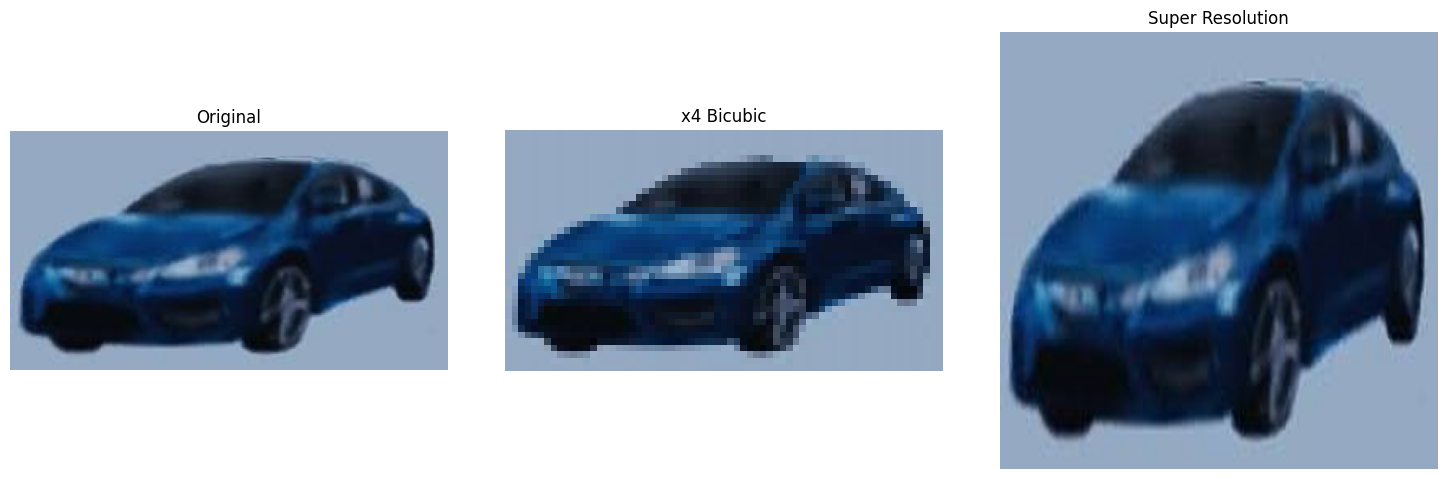

4 Chaetodon Trifascialis
=============PSNR Achieved: 38.334896==============


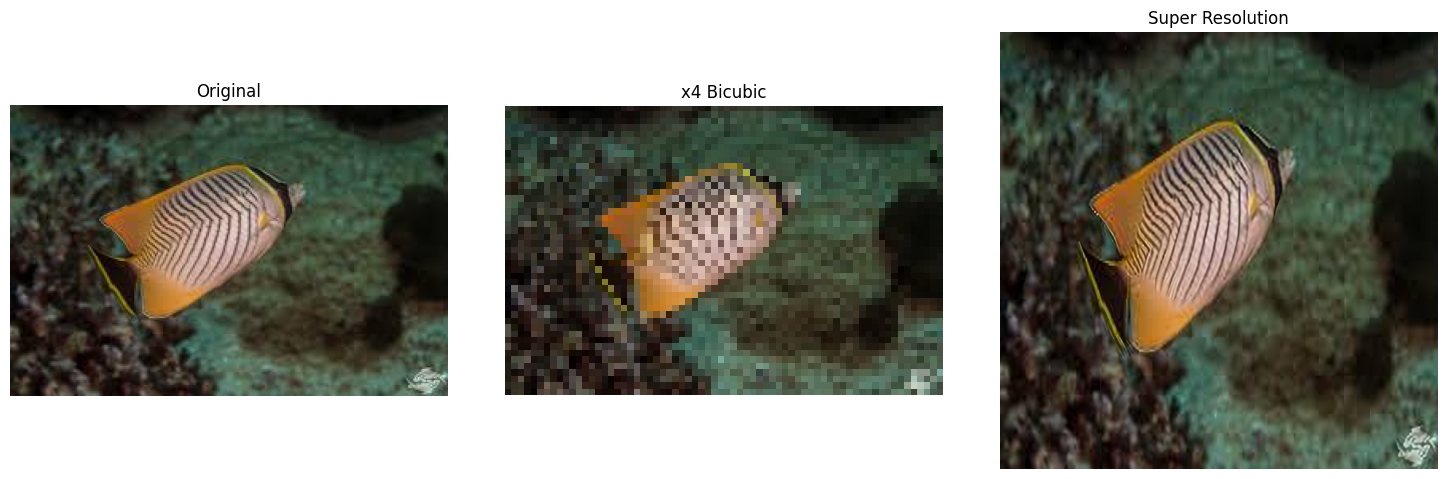

5 fish_000001229596_03681
=============PSNR Achieved: 66.877792==============


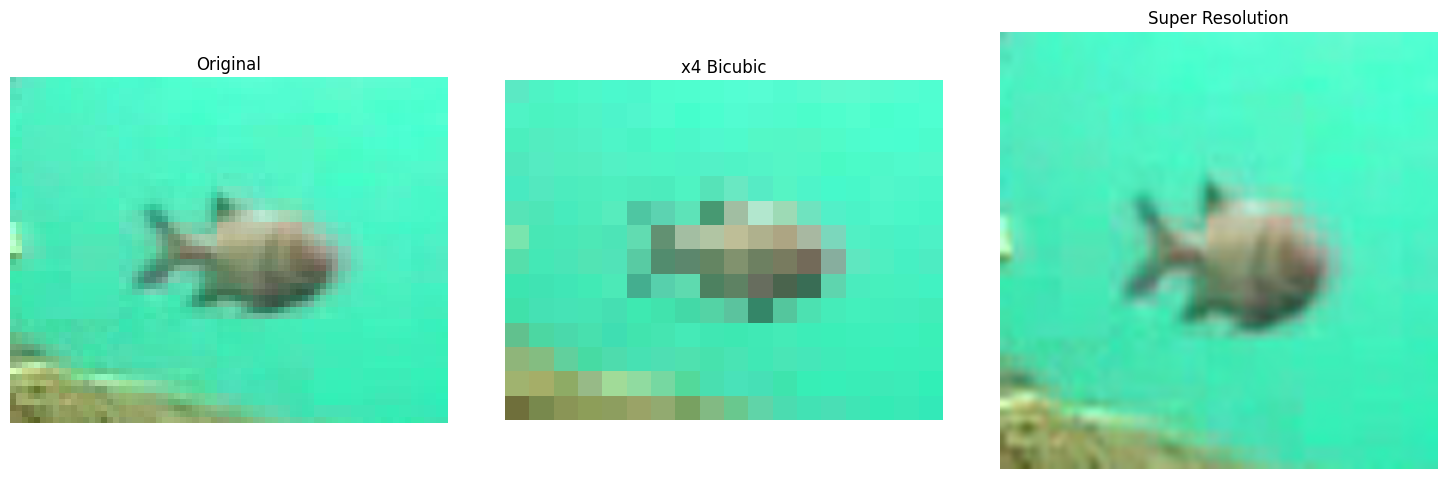

6 fish_000013099594_03543
=============PSNR Achieved: 32.837864==============


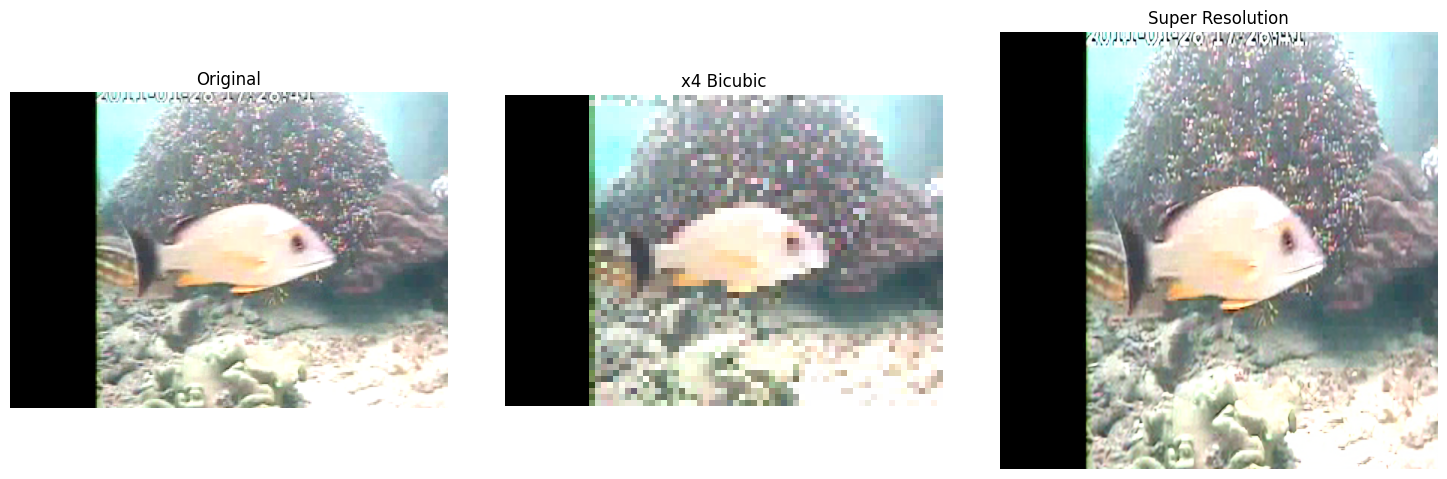

7 fish_000026690001_02685
=============PSNR Achieved: 64.426567==============


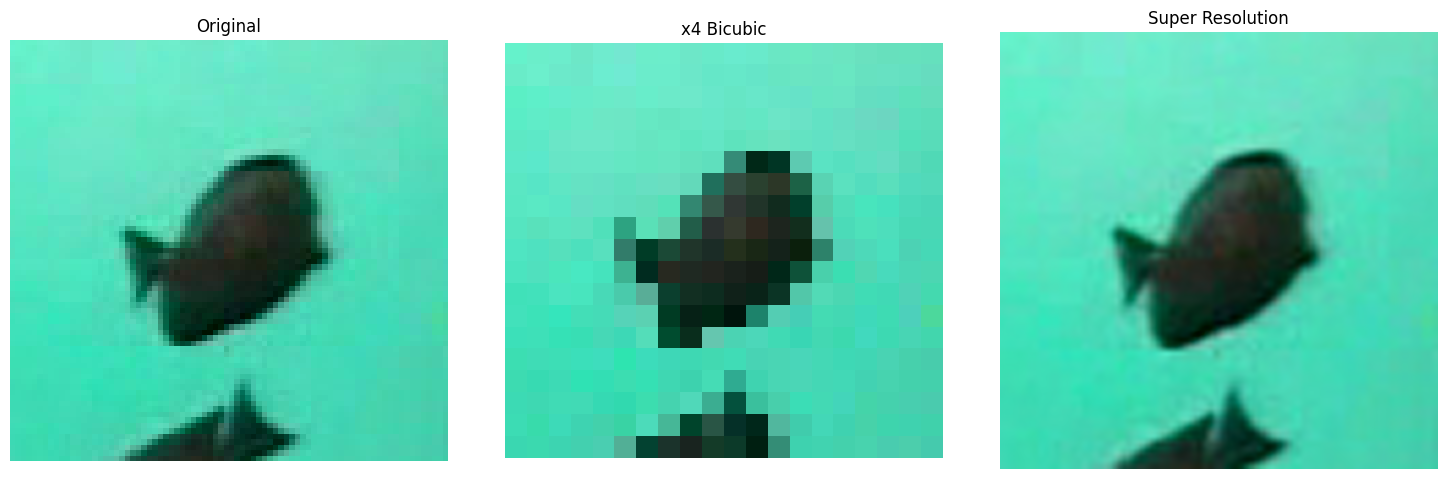

8 fish_000065789596_04756
=============PSNR Achieved: 67.100624==============


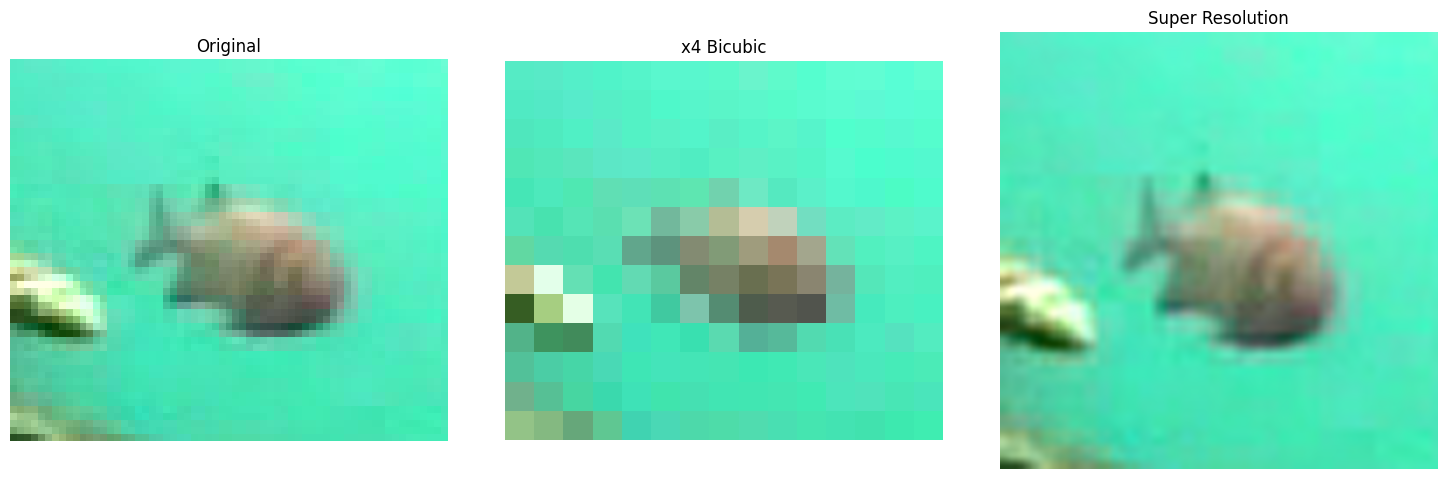

9 notenhanced
=============PSNR Achieved: 39.744598==============


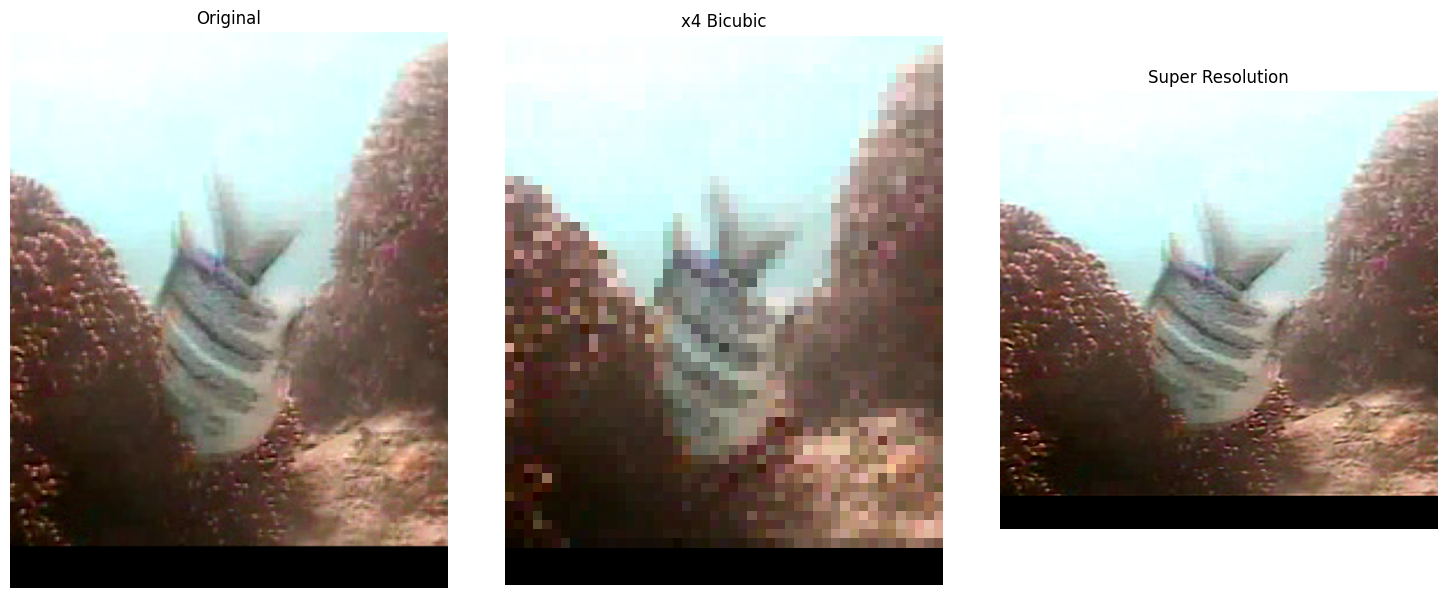

10 notenhanced2
=============PSNR Achieved: 47.370663==============


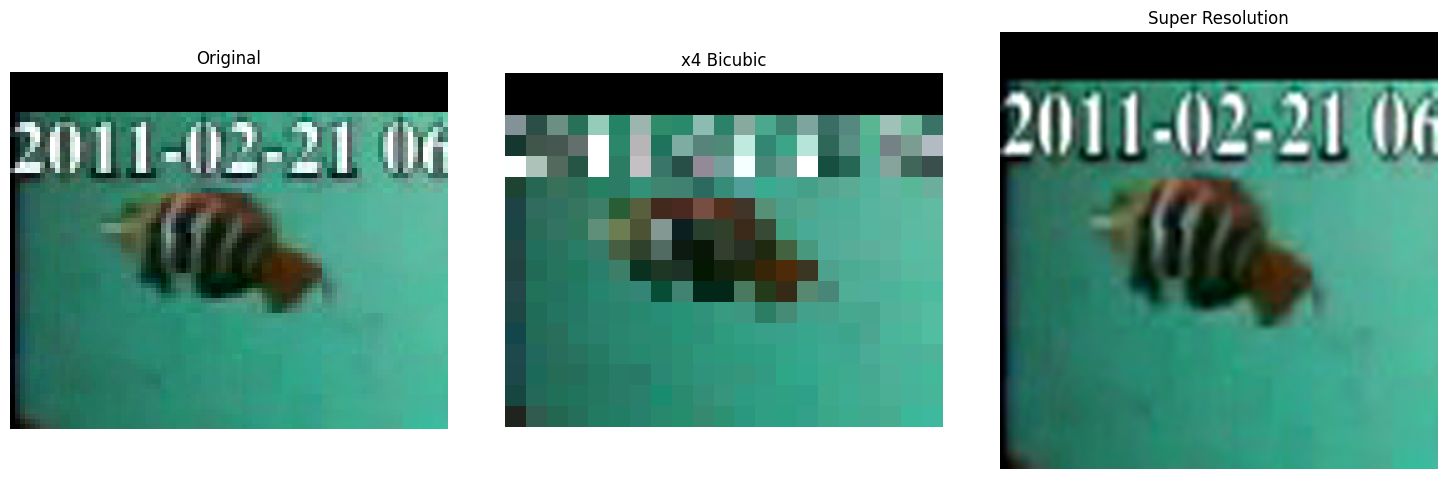

11 notenhanced3
=============PSNR Achieved: 56.800991==============


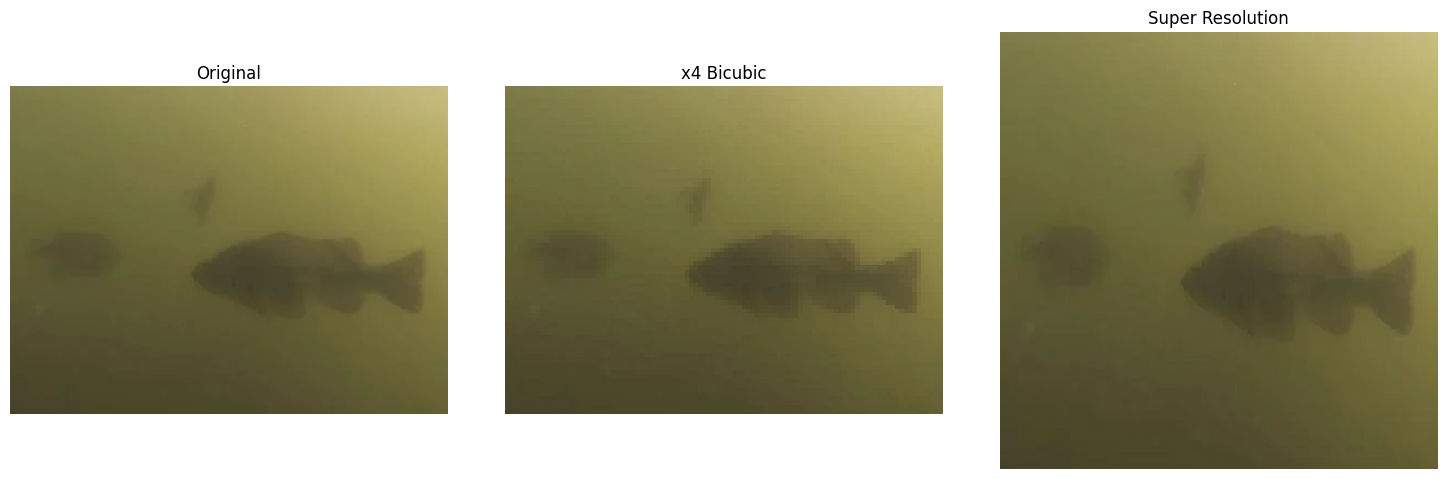

12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.628653==============


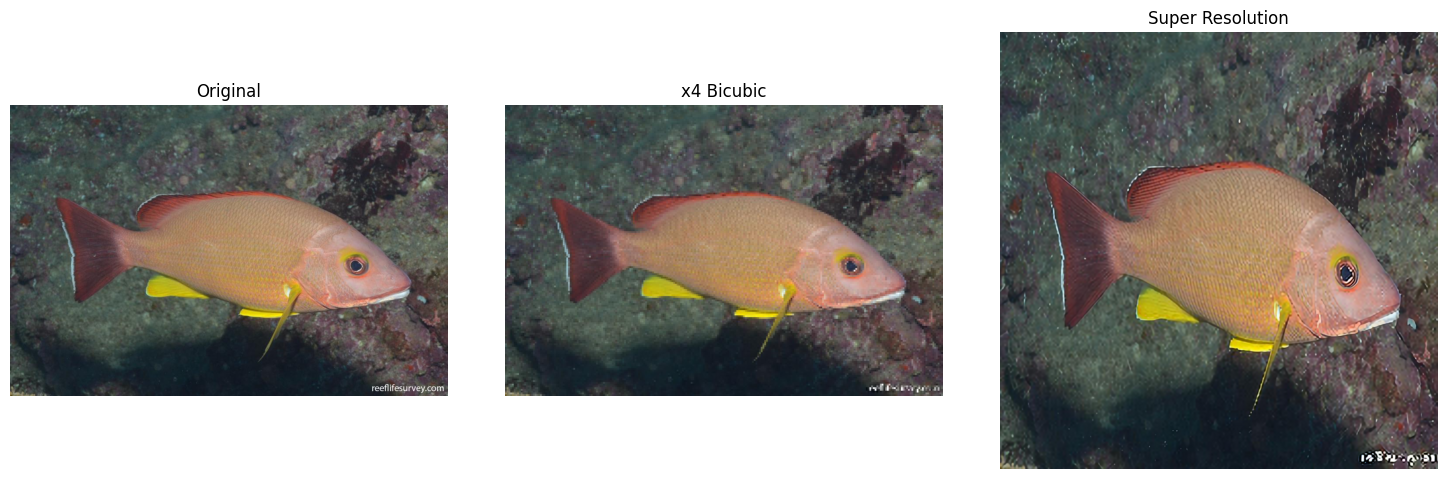

13 test_lowres
=============PSNR Achieved: 47.293438==============


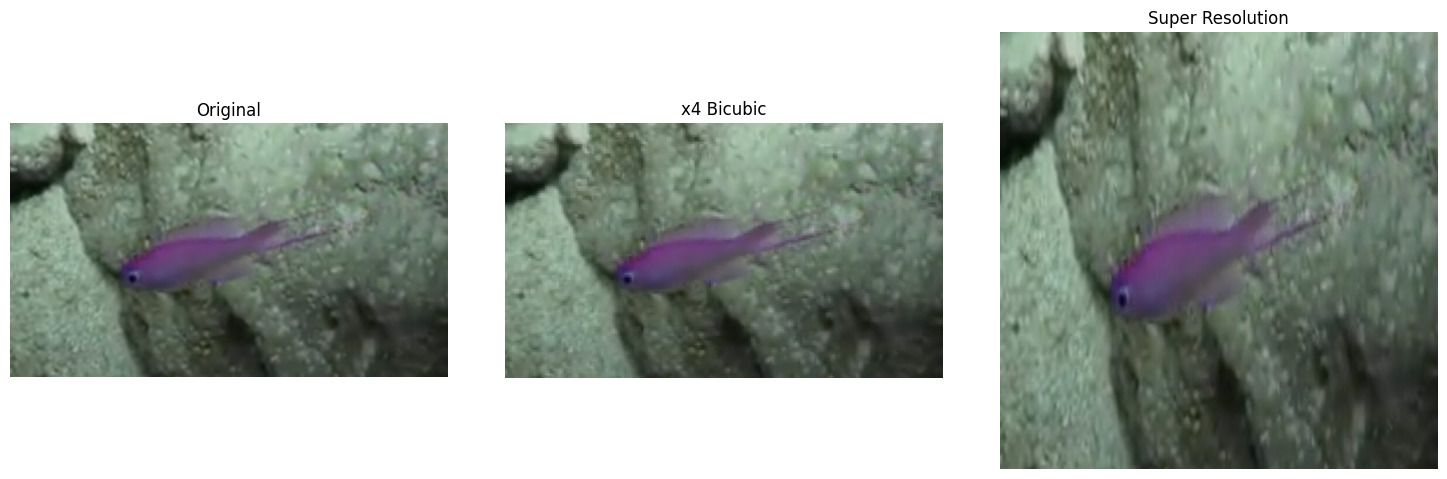

14 test_lowres3
=============PSNR Achieved: 56.408493==============


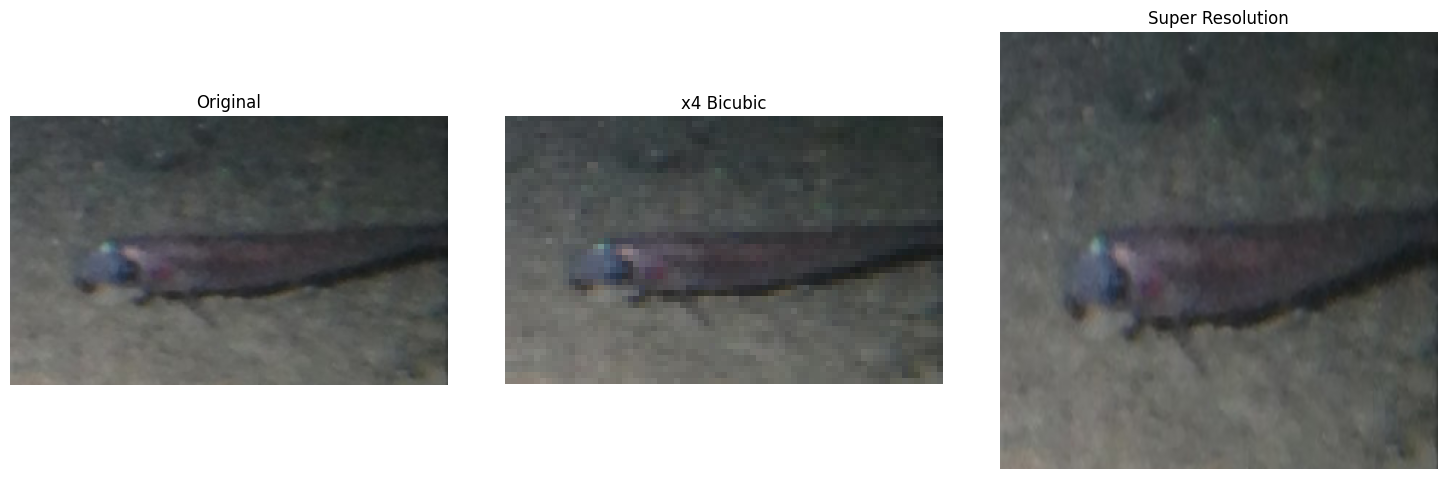

In [29]:


idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, output)

    lr_image = downscale_image(original)

    compare_images(original, lr_image, output, psnr)

    # IF SAVE IMAGE NO NEED
    # save_image2(img, "results/original", f'{idx}.png')
    # save_image2(output, "results/high", f'{idx}.png')


# RESULT PSNR TEST

BICUBIC ONLY (HIGHEST IN MODES)
1 1
=============PSNR Achieved: 41.466770==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 56.170761==============
3 car
=============PSNR Achieved: 50.163975==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 38.104820==============
5 fish_000001229596_03681
=============PSNR Achieved: 61.991138==============
6 fish_000013099594_03543
=============PSNR Achieved: 35.272121==============
7 fish_000026690001_02685
=============PSNR Achieved: 59.949650==============
8 fish_000065789596_04756
=============PSNR Achieved: 62.545822==============
9 notenhanced
=============PSNR Achieved: 39.618000==============
10 notenhanced2
=============PSNR Achieved: 46.525799==============
11 notenhanced3
=============PSNR Achieved: 58.147869==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.205925==============
13 test_lowres
=============PSNR Achieved: 47.483276==============
14 test_lowres3
=============PSNR Achieved: 56.103230==============

NEAREST ONLY
1 1
=============PSNR Achieved: 31.044752==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 85.350372==============
3 car
=============PSNR Achieved: 35.543324==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 28.711269==============
5 fish_000001229596_03681
PSNR: Infinite (identical images)
6 fish_000013099594_03543
=============PSNR Achieved: 25.851030==============
7 fish_000026690001_02685
PSNR: Infinite (identical images)
8 fish_000065789596_04756
PSNR: Infinite (identical images)
9 notenhanced
=============PSNR Achieved: 30.415329==============
10 notenhanced2
=============PSNR Achieved: 80.077400==============
11 notenhanced3
=============PSNR Achieved: 50.859493==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.373062==============
13 test_lowres
=============PSNR Achieved: 36.000317==============
14 test_lowres3
=============PSNR Achieved: 43.697029==============


BILINEAR ONLY
1 1
=============PSNR Achieved: 41.491882==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 46.213120==============
3 car
=============PSNR Achieved: 45.998062==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 34.834724==============
5 fish_000001229596_03681
=============PSNR Achieved: 50.579647==============
6 fish_000013099594_03543
=============PSNR Achieved: 32.410587==============
7 fish_000026690001_02685
=============PSNR Achieved: 48.671055==============
8 fish_000065789596_04756
=============PSNR Achieved: 50.026886==============
9 notenhanced
=============PSNR Achieved: 36.351479==============
10 notenhanced2
=============PSNR Achieved: 36.267857==============
11 notenhanced3
=============PSNR Achieved: 57.194191==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.374054==============
13 test_lowres
=============PSNR Achieved: 46.918823==============
14 test_lowres3
=============PSNR Achieved: 52.869839==============


BICUBIC+ ESRGAN (HIGHEST)
1 1
=============PSNR Achieved: 36.803761==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 63.626003==============
3 car
=============PSNR Achieved: 53.579411==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 41.632217==============
5 fish_000001229596_03681
=============PSNR Achieved: 67.875435==============
6 fish_000013099594_03543
=============PSNR Achieved: 34.387371==============
7 fish_000026690001_02685
=============PSNR Achieved: 64.947426==============
8 fish_000065789596_04756
=============PSNR Achieved: 68.226097==============
9 notenhanced
=============PSNR Achieved: 37.411011==============
10 notenhanced2
=============PSNR Achieved: 50.689159==============
11 notenhanced3
=============PSNR Achieved: 58.702293==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 29.200336==============
13 test_lowres
=============PSNR Achieved: 48.508995==============
14 test_lowres3
=============PSNR Achieved: 58.736488==============